# Probabilistic AVO analysis

## Introduction

This notebook presents an example and methodology of probabilistic amplitude variation with offset (AVO) analysis. 

Avseth, et.al. state that "*we show how we can do probabilistic AVO analysis taking into account the natural variability and uncertainties in rock properties*". 

In this example, well-log analysis (provided by Avseth, et.al.), in the key well (well 2) describe 10 different lithofacies.  These are are *shale* (`shale`), *silty shale* (`sltShale`), *clean sand* (`clnSand`), *silty sand 1* (`sltSand1`), *silty sand 2* (`sltSand2`), and *cemented sand* (`cemSand`) along with two fluid scenarios (*brine* and *oil*).

Non-parametric probability density functions (pdfs) of AVO input parameters (P-wave, S-wave and density) for the different lithofacies combinations are created and used to "*assess uncertainties in seismic signatures related to the natural variability within each facies.*"

**Extract taken from pages 225-226 (Chapter 4, Common techniques for quantitative seismic interpretation.), Quantifying AVO uncertainties related to variability in rock properties**

## Methodology

Non-parametric pdfs are created by calculating kernel density estimates (kde) of the 10 lithofacies histograms for P-wave (Vp), S-wave (Vs) and density (rho). Following this, a reflection coefficient, R, and a gradient, G, over reflection angles 0-40 degrees are calculated.  The calculation of R and G is through an AVO approximation equation (see Reference) that takes in as input Vp, Vs and rho for two adjacent rocks (cap-rock over reservoir).

Random sampling is then performed from the multi-variate (Vp-Vs-rho) kde for each lithofacies group.  

Probabilistic AVO analysis is part of a greater topic, Statistical rock physics which is covered in Chapter 3. 

## Quantifying uncertainty

The repeated random sampling and calculation of the AVO quantifies the uncertainty associated with each input log and thus the AVO response for each rock pair. 

### Import libraries

The `packages` folder contains a `function.py` file that contains some helper functions.

In [1]:
from packages.functions import *  # vshale_from_gr, vrh
import warnings
warnings.filterwarnings("ignore")

['./data/well_2.las']


### Load well data

In [2]:
df = load()[0]

### Add feature columns

Add VP, VS, VSH (IGR, Iarionov, Steiber, ), IP, IS, VP/VS, sand-shale indicator, facies code, reservoir code, 

In [3]:
well2 = well_add_features(df)

### Well header

In [4]:
well2.head()

,DEPTH,VP,VS,RHOB,GR,NPHI,IGR,VSH_clavier,VSH_larionovO,VSH_steiber,...,PHIE,IP,IS,VPVS,sandy-shaly,K0,FACIES,RESERVOIR,LABELS,FCODES
0,2013.2528,2.2947,0.8769,1.9972,91.8785,0.4908,0.493621,0.301691,0.324189,0.245246,...,0.408000,4582.97484,1751.34468,2.616832,sandy,22.676699,0,0,0,6
1,2013.4052,2.2967,0.9430,2.0455,86.8004,0.4833,0.436010,0.254496,0.273974,0.204894,...,0.377812,4697.89985,1928.90650,2.435525,sandy,24.820085,0,0,0,6
2,2013.5576,2.2904,0.9125,2.1122,86.0021,0.4474,0.426953,0.247424,0.266438,0.198944,...,0.336125,4837.78288,1927.38250,2.510027,sandy,25.646882,0,0,0,6
3,2013.7100,2.2775,0.8916,2.1960,87.3570,0.4140,0.442325,0.259481,0.279284,0.209102,...,0.283750,5001.39000,1957.95360,2.554397,sandy,25.894306,0,0,0,6
4,2013.8624,2.2620,0.8905,2.2020,90.4024,0.4293,0.476875,0.287567,0.309177,0.233048,...,0.280000,4980.92400,1960.88100,2.540146,sandy,25.048897,0,0,0,6


### Well plot

Reference: Agile Geoscience

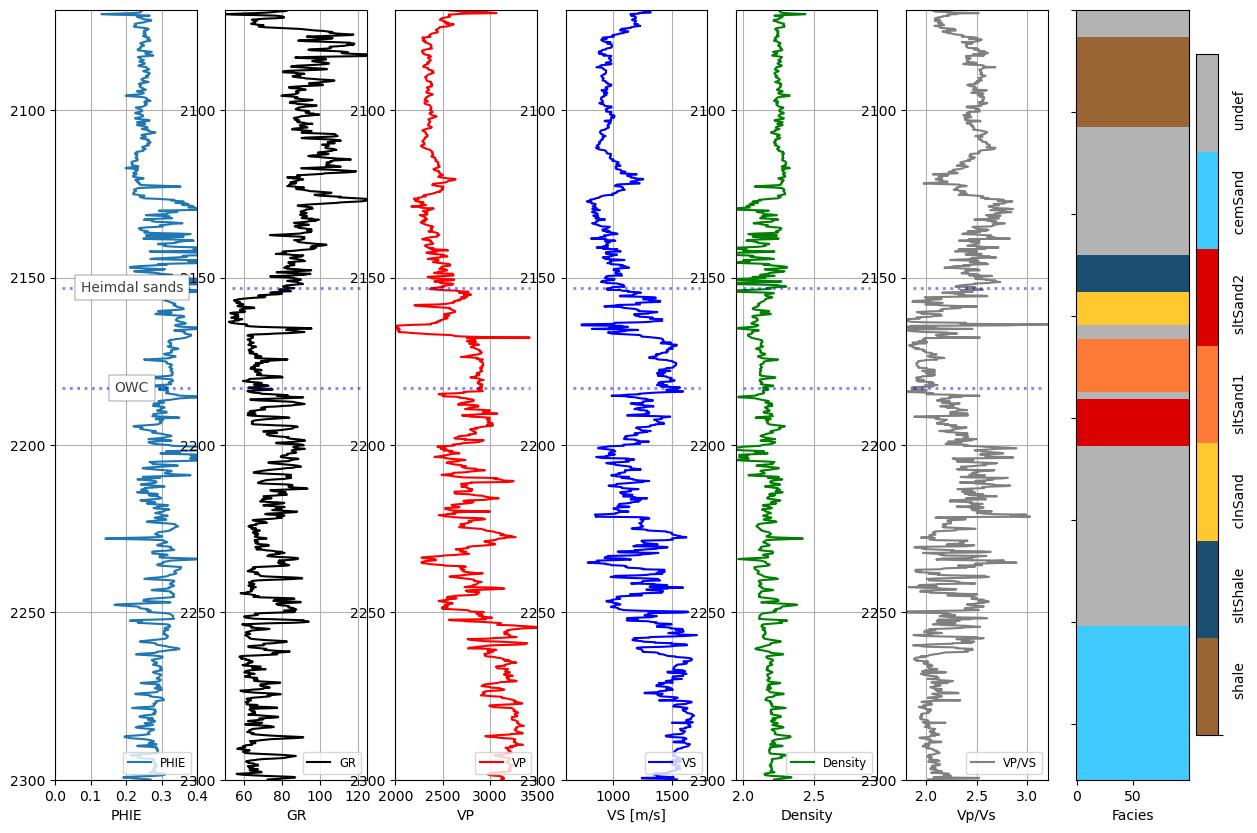

In [5]:
import matplotlib.colors as colors
ccc = ['#996633', '#1B4F72', '#FFC82E','#FF7A36', '#DB0000', '#40CBFF', '#B3B3B3']
cmap_facies = colors.ListedColormap(ccc[0:len(ccc)], 'indexed')

ztop=2070; zbot=2300  #ztop=2140; zbot=2200
ll=well2[(well2.DEPTH>=ztop) & (well2.DEPTH<=zbot)]

cluster=np.repeat(np.expand_dims(ll['FCODES'].values,1), 100, 1)

f, ax = plt.subplots(nrows=1, ncols=7, figsize=(15, 10))

ax[0].plot(ll.PHIE,    ll.DEPTH,         label='PHIE')
ax[1].plot(ll.GR,      ll.DEPTH, '-k',   label='GR')
ax[2].plot(ll.VP*1000, ll.DEPTH, '-r',   label='VP')
ax[3].plot(ll.VS*1000, ll.DEPTH, 'blue', label='VS')
ax[4].plot(ll.RHOB,    ll.DEPTH, '-g',   label='Density')
ax[5].plot(ll.VPVS,    ll.DEPTH, '-', color='0.5', label='VP/VS')
im=ax[6].imshow(cluster, interpolation='none', aspect='auto',cmap=cmap_facies,vmin=0,vmax=len(ax)-1)#4)

cbar=plt.colorbar(im, ax=ax[6], aspect=32)
cbar.set_label((9*' ').join(['shale', 'sltShale', 'clnSand', 'sltSand1', 'sltSand2', 'cemSand', 'undef']))
cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

for i in range(len(ax)-1):
    ax[i].set_ylim(ztop,zbot)
    ax[i].invert_yaxis()
    ax[i].grid()
    ax[i].locator_params(axis='x', nbins=4)
    ax[i].legend(fontsize='small', loc='lower right')

ax[0].set_xlabel("PHIE"),          ax[0].set_xlim(0,0.4)
ax[1].set_xlabel("GR"),            ax[1].set_xlim(50, 125),
ax[2].set_xlabel("VP"),            ax[2].set_xlim(2000, 3500),
ax[4].set_xlabel("Density"),       ax[4].set_xlim(1.95, 2.95),
ax[3].set_xlabel("VS [m/s]"),      ax[3].set_xlim(600, 1800),
ax[5].set_xlabel("Vp/Vs"),         ax[5].set_xlim(1.8,3.2),
ax[6].set_xlabel('Facies'),  ax[6].set_yticklabels([])

tops = {
    "Heimdal sands": 2153,
    "OWC": 2183,
}

for i in range(len(ax)-1):
    for top in tops.values() :
        f.axes[i].axhline( y = float(top), color = 'b', lw = 2, 
                            ls = ':',  
                            alpha = 0.5, xmin = 0.05, xmax = 0.95 )
        
for top, depth in tops.items():
    if (ztop < depth < zbot):
        ax[1].text( x = max(ax[0].xaxis.get_data_interval())*1.0,
                  y = float(depth), s = top,
                             alpha=0.75, color='k',
                             fontsize = '10',
                             horizontalalignment = 'center',
                             verticalalignment = 'center',
                             bbox=dict(facecolor='white', alpha=1.0, lw = 0.25),
                             weight = 'light');

### Well log section
Well 2 around the reservoir section.  `sltShale` is cap-rock in this well, with `clnSand`, and `sltSand1` being oil bearing and with `sltSand2` and `cemSand` being below the oil water contact (OWC).

### Data histograms and resultant kernel estimates

The plot below shows the P-wave histograms and the calculated kernel estimates.

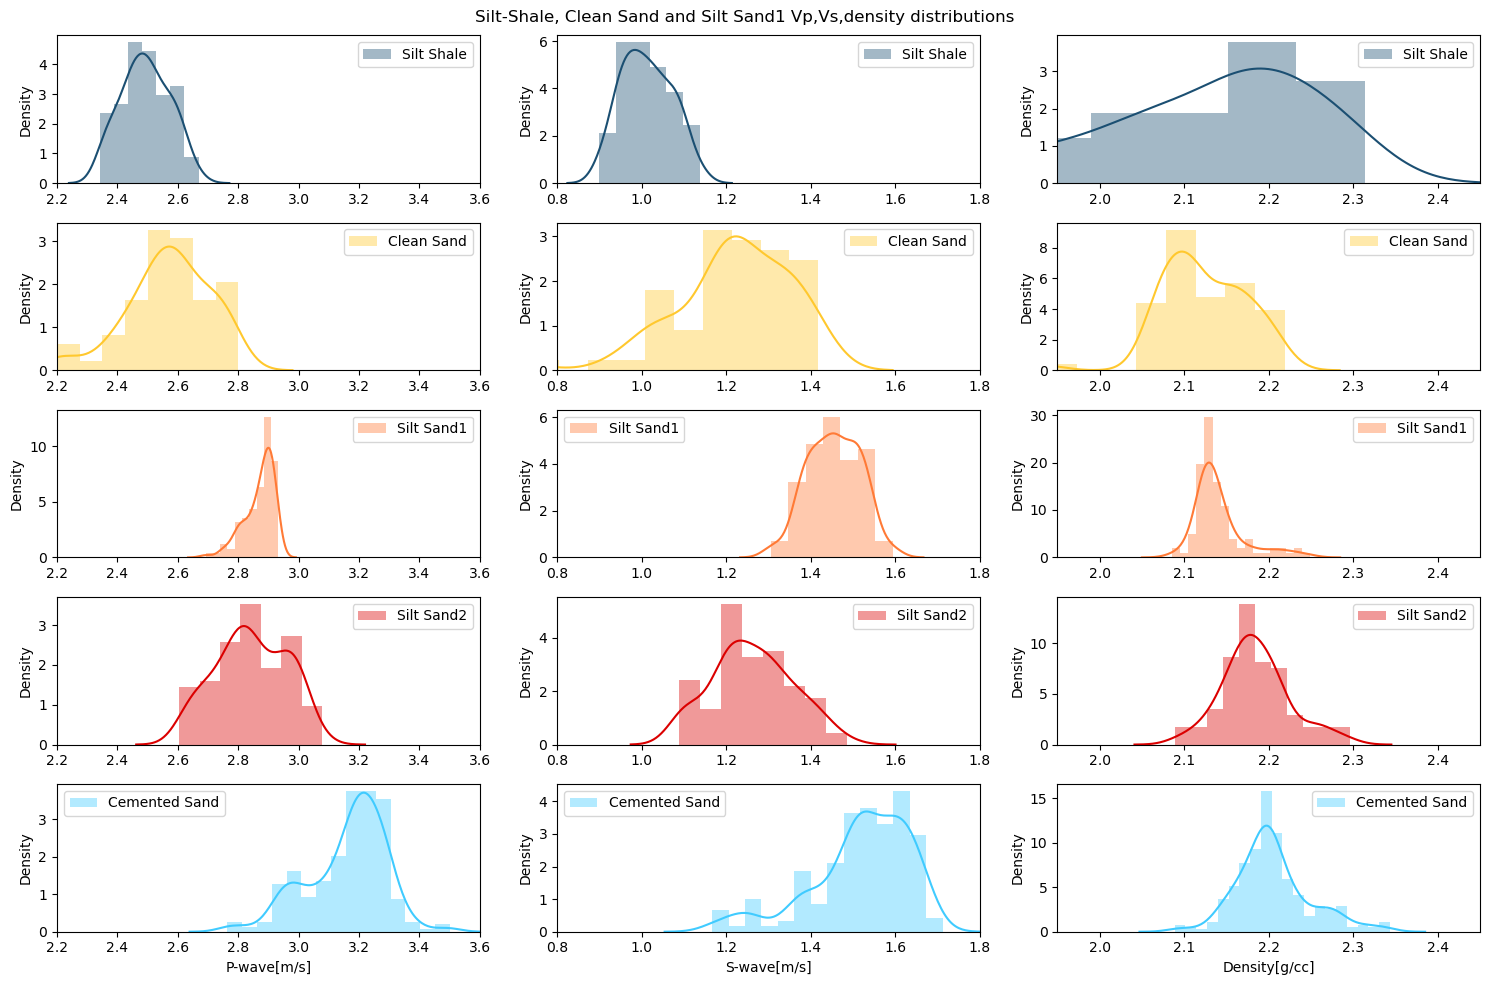

In [6]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,ax11,ax12),(ax13,ax14,ax15)) = plt.subplots(5, 3, figsize=(15,10))  # sharey=True, 
fig.suptitle('Silt-Shale, Clean Sand and Silt Sand1 Vp,Vs,density distributions')

sns.distplot(ax=ax1, x=well2[well2.LABELS=='sltShale']['VP'], color=ccc[1], label="Silt Shale")
sns.distplot(ax=ax2, x=well2[well2.LABELS=='sltShale']['VS'], color=ccc[1], label="Silt Shale")
sns.distplot(ax=ax3, x=well2[well2.LABELS=='sltShale']['RHOB'], color=ccc[1], label="Silt Shale")
sns.distplot(ax=ax4, x=well2[well2.LABELS=='clnSand']['VP'], color=ccc[2], label="Clean Sand")
sns.distplot(ax=ax5, x=well2[well2.LABELS=='clnSand']['VS'], color=ccc[2], label="Clean Sand")
sns.distplot(ax=ax6, x=well2[well2.LABELS=='clnSand']['RHOB'], color=ccc[2], label="Clean Sand")
sns.distplot(ax=ax7, x=well2[well2.LABELS=='sltSand1']['VP'], color=ccc[3], label="Silt Sand1")
sns.distplot(ax=ax8, x=well2[well2.LABELS=='sltSand1']['VS'], color=ccc[3], label="Silt Sand1")
sns.distplot(ax=ax9, x=well2[well2.LABELS=='sltSand1']['RHOB'], color=ccc[3], label="Silt Sand1")

sns.distplot(ax=ax10, x=well2[well2.LABELS=='sltSand2']['VP'], color=ccc[4], label="Silt Sand2")
sns.distplot(ax=ax11, x=well2[well2.LABELS=='sltSand2']['VS'], color=ccc[4], label="Silt Sand2")
sns.distplot(ax=ax12, x=well2[well2.LABELS=='sltSand2']['RHOB'], color=ccc[4], label="Silt Sand2")
sns.distplot(ax=ax13, x=well2[well2.LABELS=='cemSand']['VP'], color=ccc[5], label="Cemented Sand")
sns.distplot(ax=ax14, x=well2[well2.LABELS=='cemSand']['VS'], color=ccc[5], label="Cemented Sand")
sns.distplot(ax=ax15, x=well2[well2.LABELS=='cemSand']['RHOB'], color=ccc[5], label="Cemented Sand")

ax1.set_xlim(2.2,3.6), ax2.set_xlim(0.8,1.8), ax3.set_xlim(1.95,2.45)
ax4.set_xlim(2.2,3.6), ax5.set_xlim(0.8,1.8), ax6.set_xlim(1.95,2.45)
ax7.set_xlim(2.2,3.6), ax8.set_xlim(0.8,1.8), ax9.set_xlim(1.95,2.45)
ax10.set_xlim(2.2,3.6), ax11.set_xlim(0.8,1.8), ax12.set_xlim(1.95,2.45)
ax13.set_xlim(2.2,3.6), ax14.set_xlim(0.8,1.8), ax15.set_xlim(1.95,2.45)
ax13.set_xlabel('P-wave[m/s]'), ax14.set_xlabel('S-wave[m/s]'), ax15.set_xlabel('Density[g/cc]')

plt.tight_layout()
for ax in fig.get_axes():
    ax.legend()
    #ax.label_outer()

**(above)** The rows represent the P-wave, S-wave and density of a particular lithofacies.  The columns show the comparison of each lithofacies distribution for each log. 

### Bivariate distribution of P-wave versus S-wave

The plot below demonstrates kernel density estimate of the bivaritate distributions P-wave and S-wave for `sltShale`, `clnSand` and `sltSand1` in plot one and `sltShale`, `sltSand2` and `cemSand` in plot two. This plot shows the two-dimensional distributions of each of the three lithofacies. 

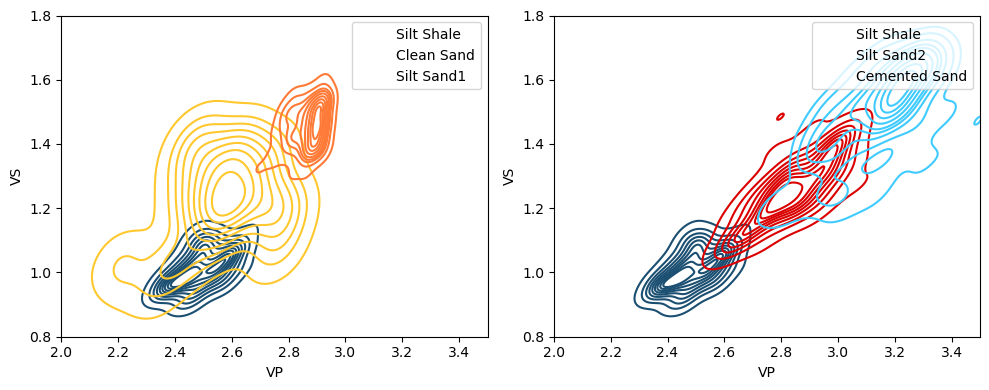

In [7]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.kdeplot(ax=ax[0], data=well2[well2.LABELS=='sltShale'], x='VP', y='VS', color=ccc[1], label="Silt Shale")
sns.kdeplot(ax=ax[0], data=well2[well2.LABELS=='clnSand'], x='VP', y='VS', color=ccc[2], label="Clean Sand")
sns.kdeplot(ax=ax[0], data=well2[well2.LABELS=='sltSand1'], x='VP', y='VS', color=ccc[3], label="Silt Sand1")

sns.kdeplot(ax=ax[1], data=well2[well2.LABELS=='sltShale'], x='VP', y='VS', color=ccc[1], label="Silt Shale")
sns.kdeplot(ax=ax[1], data=well2[well2.LABELS=='sltSand2'], x='VP', y='VS', color=ccc[4], label="Silt Sand2")
sns.kdeplot(ax=ax[1], data=well2[well2.LABELS=='cemSand'], x='VP', y='VS', color=ccc[5], label="Cemented Sand")

ax[0].set_xlim(2.,3.5); ax[1].set_xlim(2.,3.5)
ax[0].set_ylim(0.8, 1.8); ax[1].set_ylim(0.8,1.8)

plt.tight_layout()
for ax in fig.get_axes():
    ax.legend()
    #ax.label_outer()

### Monte-Carlo simulation from non-parametric distributions

The function `kde_resample()` creates three-dimensional (3D) kernel density estimates (kde's) for each lithofacies/fluid scenario distribution.  

Once the kde has been calculated, the resampling method is called for a specified number of times (here 500).  The output of the function is then input to the `r0g()` function below.

In [8]:
lith_list = ['sltShale', 'clnSand', 'sltSand1', 'sltSand2', 'cemSand']
column = 'LABELS'
logs = ['VP', 'VS', 'RHOB']
num_samples = 500

kde = kde_resample(well2, column, lith_list, logs, num_samples=1000)

### Calculate R0-G from simulated distributions

The function `r0g()` samples Vp, Vs & rho from the simulated cap-rock kde, `sltShale`, and then the simulated reservoir (`clnSand`, `sltSand1`, `sltSand2` and `cemSand`) kde.  The parameters from each lithology are then input to the equation (see References) to obtain a reflection coefficient (R0) and gradient (G) which is then used to determine the reflection coefficient for a particular angle theta for theta between 0-40 degrees.

The median of all sampled data for each value of theta is calculated.

In [9]:
# Assumes that cap rock is in position 0
# ------------------------------ r0g(vp0      , vs0      , rho0     , vp1      , vs1      , rho1)
r01_b, G1_b, Rtheta1_b, med1_b = r0g(kde[0][0], kde[0][1], kde[0][2], kde[1][0], kde[1][1], kde[1][2])
r02_b, G2_b, Rtheta2_b, med2_b = r0g(kde[0][0], kde[0][1], kde[0][2], kde[2][0], kde[2][1], kde[2][2])
r03_b, G3_b, Rtheta3_b, med3_b = r0g(kde[0][0], kde[0][1], kde[0][2], kde[3][0], kde[3][1], kde[3][2])
r04_b, G4_b, Rtheta4_b, med4_b = r0g(kde[0][0], kde[0][1], kde[0][2], kde[4][0], kde[4][1], kde[4][2])
#r05_b, G5_b, Rtheta5_b, med5_b = r0g(kde[0][0], kde[0][1], kde[0][2], kde[5][0], kde[5][1], kde[5][2])

rc_list = [r01_b, r02_b, r03_b, r04_b]
G_list = [G1_b, G2_b, G3_b, G4_b]
Rtheta_list = [Rtheta1_b, Rtheta2_b, Rtheta3_b, Rtheta4_b]
med_list = [med1_b, med2_b, med3_b, med4_b]

### Plot R0-G and Amplitude versus angle for each pair

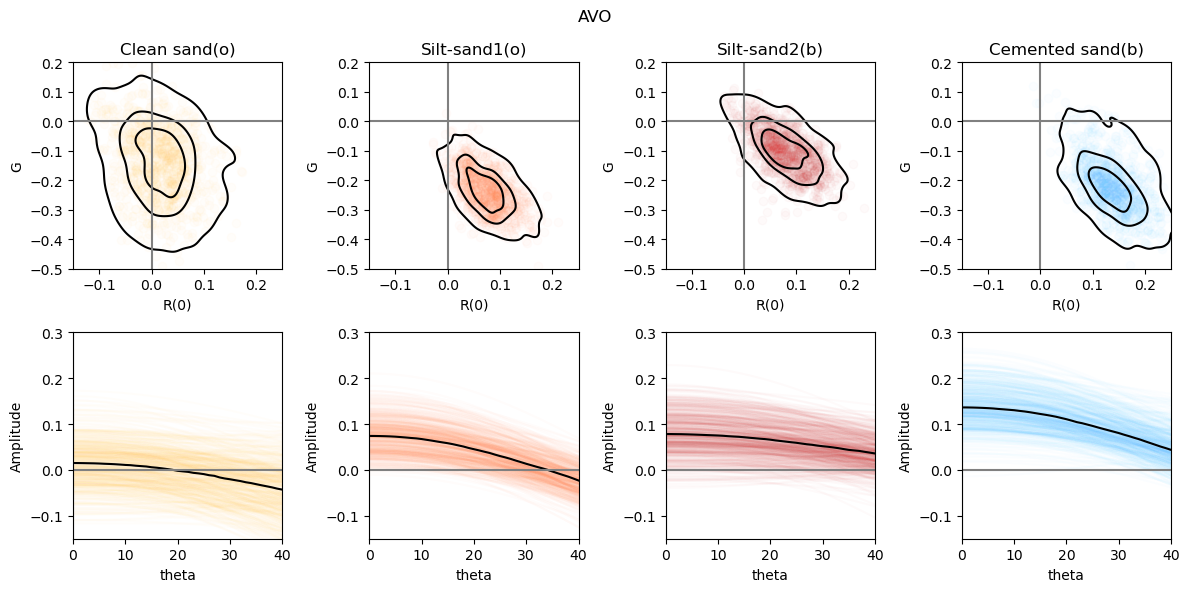

In [10]:
alpha1=0.02
alpha2=0.02
titles = ['Clean sand(o)', 'Silt-sand1(o)', 'Silt-sand2(b)', 'Cemented sand(b)']

fig, ax = plt.subplots(2, 4, squeeze=False, figsize=(12,6))
fig.suptitle('AVO')

# plot first row: 
for i in range(4):
    ax[0,i].set_title(titles[i])
    ax[0,i].scatter(rc_list[i], G_list[i], alpha=alpha1, color=ccc[i+2])
    sns.kdeplot(ax=ax[0,i], x=rc_list[i], y=G_list[i], color='k', linestyles="-", levels=4)
    ax[0,i].set_xlabel("R(0)"); ax[0,i].set_ylabel("G")
    ax[0,i].set_xlim(-0.15, 0.25); ax[0,i].set_ylim(-0.5, 0.2)
    ax[0,i].axvline(0, color='gray')
    ax[0,i].axhline(0, color='gray')
    
# plot second row
for j in range(4):
    for i in range(num_samples):
        ax[1,j].plot(Rtheta_list[j][i][0], alpha=alpha2, color=ccc[j+2])
    ax[1,j].plot(med_list[j], 'k')
    ax[1,j].set_xlabel("theta"); ax[1,j].set_ylabel("Amplitude")
    ax[1,j].set_xlim(0,40); ax[1,j].set_ylim(-0.15, 0.3)
    ax[1,j].axvline(0, color='gray')
    ax[1,j].axhline(0, color='gray')

plt.tight_layout()
plt.savefig('Probabilistic_AVO_analysis_a.png');

**Top row**:  Bivariate distribution of the different seismic lithofacies in the R(0)-G plane, assuming silty shale is the cap rock.  The centre of each contour plot represents the most likely set of R(0) and G for each facies. The contours represent iso-probability values, decreasing away from the innermost contour.

**Bottom row**: AVO pdfs for each lithofacies pair. The cap-rock is represented by a silty shale.  The superimposed black lines are the deterministic AVO responses calculated from the median values of the pdfs.  The equation $R(\theta) \approx R(0) + G\sin^2\theta$ is used to calculate these pdfs.

## References

* Avseth, P., Mukerji, T. & Mavko, G. Quantitative Seismic Interpretation. (Cambridge University Press, 2005).

### Equations
$R(\theta_1)\approx \dfrac{1}{2}\big(1-4p^2V_S^2\big)\dfrac{\Delta \rho}{\rho}+\dfrac{1}{2\cos^2\theta}\dfrac{\Delta V_P}{V_P}-4p^2V_S^2\dfrac{\Delta V_S}{V_S}$